In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn, spherical_yn

In [2]:
def Pn(n: int, x: np.array):
    if np.max(np.abs(x)) > 1:
        raise ValueError("|x| must be smaller than 1!")

    pn = np.zeros((x.size, n + 1))
    pn[:, 0] = 1
    if n >= 1:
        pn[:, 1] = x

    for nn in range(1, n):
        pn[:, nn + 1] = ((2 * nn + 1) * x * pn[:, nn] - nn * pn[:, nn - 1]) / (nn + 1)

    return pn[:, n]

In [3]:
x = np.array([0.1, 0.5, 0.9])
n = 3

In [4]:
Pn(n, x)

array([-0.1475, -0.4375,  0.4725])

In [5]:
def fluid_fs(scale, out_flag, para):
    DEG2RAD = np.pi / 180
    ns, x0, xe, g, h = para[:5]
    
    # Create ka array
    if scale == 1:
        ka1 = np.linspace(x0, xe, ns)
    else:
        ka1 = np.logspace(np.log10(x0), np.log10(xe), ns)

    # Determine max mode
    if len(para) < 7:
        Nmax = round(np.max(ka1)) + 10
    else:
        Nmax = para[6]

    ka2 = ka1 / h
    m = len(ka1)
    theta = para[5] * DEG2RAD
    x = np.cos(theta)

    n = np.arange(Nmax)
    nl = 2 * n + 1

    # Compute Legendre polynomials Pn(x)
    pn1 = np.array([Pn(ni, x) for ni in n]).squeeze()

    # Bessel functions and derivatives
    jn1 = np.array([spherical_jn(ni, ka1) for ni in n])  # shape (Nmax, m)
    yn1 = np.array([spherical_yn(ni, ka1) for ni in n])
    djn1 = np.array([spherical_jn(ni, ka1, derivative=True) for ni in n])
    dyn1 = np.array([spherical_yn(ni, ka1, derivative=True) for ni in n])

    jn2 = np.array([spherical_jn(ni, ka2) for ni in n])
    djn2 = np.array([spherical_jn(ni, ka2, derivative=True) for ni in n])

    # Avoid division warnings
    with np.errstate(divide='ignore', invalid='ignore'):
        term1 = djn2 * yn1 / (jn2 * djn1) - g * h * dyn1 / djn1
        term2 = djn2 * jn1 / (jn2 * djn1) - g * h
        cn = term1 / term2
        bn = -1 / (1 + 1j * cn)

    # Form function f and amplitude S
    f = np.zeros(m, dtype=complex)
    # S = np.zeros((m, Nmax), dtype=complex)
    for mm in range(m):
        s = nl * pn1 * bn[:, mm]
        f[mm] = np.sum(s)
        # S[mm, :] = s / ka1[mm]

    outx = ka1
    # Choose output based on out_flag
    if out_flag == 1:
        outy = np.abs(2 * f / ka1)  # Modulus of form function
    elif out_flag == 2:
        outy = -1j * 2 * f / ka1  # Complex form function
    elif out_flag == 3:
        outy = np.abs(f) / (np.sqrt(np.pi) * ka1)  # Modulus of normalized scattering amplitude
    elif out_flag == 4:
        outy = -1j * f / (np.sqrt(np.pi) * ka1)  # Complex normalized scattering amplitude
    else:
        raise ValueError("Invalid out_flag value.")

    return outx, outy

In [6]:
# para_fld=[n, x0, xe, g, h, theta_ka]
para = [1000, 0.001, 20, 0.0012, 0.22, 180]  # bubble at surface
# para = [1000, 0.001, 20, 1.026, 1.017, 180]  # fluid sphere
scale = 2
out_flag = 1  # modulus of form function

ka, fm = fluid_fs(scale, out_flag, para)

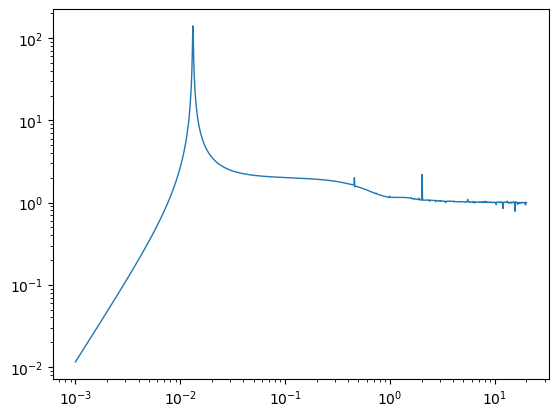

In [7]:
plt.loglog(ka,abs(fm), lw=1)

In [8]:
ka.min(), ka.max()

(np.float64(0.001), np.float64(20.000000000000004))

In [9]:
a = 0.01  # radius [m]

In [10]:
c = 1500
freq = ka * c / (a * 2 * np.pi)

In [11]:
TS = 20 * np.log10(np.abs(fm) * a/2)

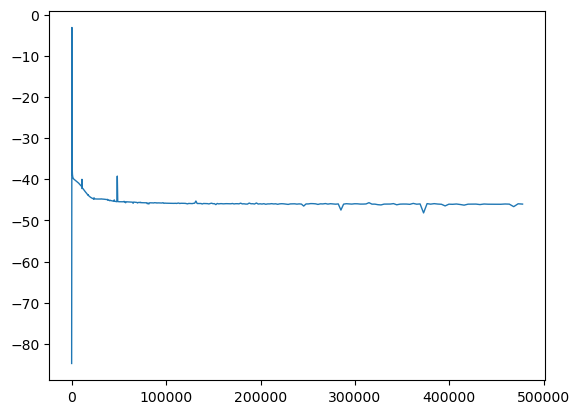

In [12]:
plt.plot(freq, TS, lw=1)

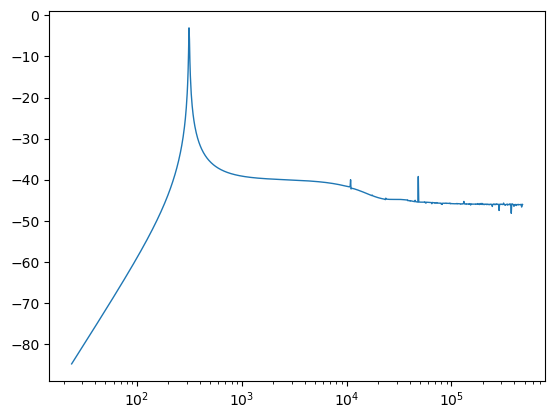

In [13]:
plt.plot(freq, TS, lw=1)
plt.xscale("log")

In [14]:
np.log10(freq.min()), np.log10(freq.max())

(np.float64(1.3779113906975662), np.float64(5.678941386361547))

In [15]:
freq.min(), freq.max()

(np.float64(23.8732414637843), np.float64(477464.82927568606))

In [16]:
def elastic_fs(scale, out_flag, para):
    DEG2RAD = np.pi / 180
    ns, x0, xe, g, hc, hs = para[:6]

    # Create ka values
    if scale == 1:
        ka1 = np.linspace(x0, xe, ns)
    else:
        ka1 = np.logspace(np.log10(x0), np.log10(xe), ns)

    ka2L = ka1 / hc
    ka2s = ka1 / hs
    m = len(ka1)

    # Set Nmax
    if len(para) < 8:
        Nmax = round(np.max(ka1)) + 10
    else:
        Nmax = para[7]

    theta = para[6] * DEG2RAD
    x = np.cos(theta)

    n = np.arange(Nmax)
    nl = 2 * n + 1
    pn = np.array([Pn(ni, x) for ni in n]).squeeze()

    # Spherical Bessel functions
    jn1 = np.array([spherical_jn(ni, ka1) for ni in n])
    yn1 = np.array([spherical_yn(ni, ka1) for ni in n])
    djn1 = np.array([spherical_jn(ni, ka1, derivative=True) for ni in n])
    dyn1 = np.array([spherical_yn(ni, ka1, derivative=True) for ni in n])

    jn2L = np.array([spherical_jn(ni, ka2L) for ni in n])
    djn2L = np.array([spherical_jn(ni, ka2L, derivative=True) for ni in n])
    jn2s = np.array([spherical_jn(ni, ka2s) for ni in n])
    djn2s = np.array([spherical_jn(ni, ka2s, derivative=True) for ni in n])

    f = np.zeros(m, dtype=complex)

    nn = n * n + n  # shape (Nmax,)
    
    # Compute tan terms (shape: Nmax x m)
    tan1 = -ka2L * djn2L / jn2L
    tan2 = -ka2s * djn2s / jn2s
    tan3 = -ka1 * djn1 / jn1
    tan_beta = -ka1 * dyn1 / yn1
    tan_del = -jn1 / yn1

    d1 = tan1 + 1
    d2 = nn[:, None] - 1 - (ka2s**2)[None, :] / 2 + tan2

    term1a = tan1 / d1
    term1b = nn[:, None] / d2
    term2a = (nn[:, None] - (ka2s**2)[None, :] / 2 + 2 * tan1) / d1
    term2b = nn[:, None] * (tan2 + 1) / d2

    td = -0.5 * (ka2s**2)[None, :] * (term1a - term1b) / (term2a - term2b)
    tan_phi = -td / g
    tan_eta = tan_del * (tan_phi + tan3) / (tan_phi + tan_beta)

    cos_eta = 1 / np.sqrt(1 + tan_eta**2)
    sin_eta = tan_eta * cos_eta

    bn = sin_eta * (1j * cos_eta - sin_eta)  # shape: (Nmax, m)
    s = nl[:, None] * pn[:, None] * bn       # shape: (Nmax, m)
    f = np.sum(s, axis=0)                    # shape: (m,)

    outx = ka1
    if out_flag == 1:
        outy = np.abs(2 * f / ka1)
    elif out_flag == 2:
        outy = -1j * 2 * f / ka1
    elif out_flag == 3:
        outy = np.abs(f) / (np.sqrt(np.pi) * ka1)
    elif out_flag == 4:
        outy = -1j * f / (np.sqrt(np.pi) * ka1)
    else:
        raise ValueError("Invalid out_flag value.")

    return outx, outy

In [17]:
c = 1500
freq = np.array([0.001, 30]) * c / (a * 2 * np.pi)
freq

array([2.38732415e+01, 7.16197244e+05])

In [18]:
# para_fld=[n x0 xe g hc hs theta_ka]
para = [1000, 0.001, 30, 7.8, 3.74, 2.08, 180]  # stainless steel
scale = 2
out_flag = 1  # modulus of form function

ka, fm = elastic_fs(scale, out_flag, para)

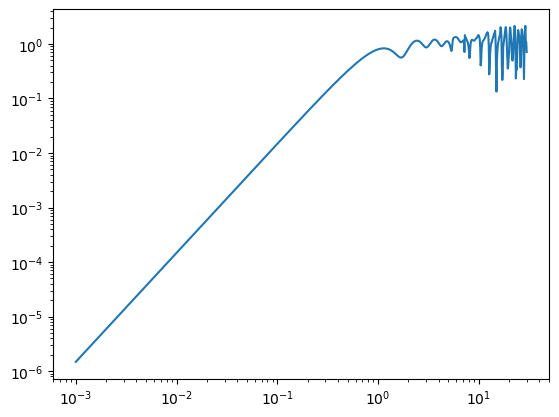

In [19]:
plt.loglog(ka,abs(fm))

In [20]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')

import ipywidgets as widgets

from IPython.display import display, HTML

In [21]:
# para_fld=[n, x0, xe, g, h, theta_ka]
para_fluid = [1000, 0.001, 25, 1.026, 1.017, 180]  # fluid sphere
scale = 2
out_flag = 2  # complex form function

ka, fm_fluid = fluid_fs(scale, out_flag, para_fluid)

c = 1500  # medium sound speed [m/s]

def fluid_TS(radius, xscale_type):
    freq = ka * c / (radius * 2 * np.pi)
    TS = 20 * np.log10(np.abs(fm_fluid) * radius/2)
    plt.figure(figsize=(5,3.5))
    plt.plot(freq, TS, lw=1)
    if xscale_type == "log":
        plt.xlim(23, 6e3)
        plt.xscale("log")
    else:
        plt.xlim(0, 6e3)
    plt.ylim(-100, -30)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("TS (dB)")
    plt.title("Scattering from a fluid sphere")
    plt.show


# rr = np.hstack(((np.arange(5, 10, 1)/100), np.arange(1, 10, 1)/10))
rr = np.arange(1, 10, 1)/10
radius_slider = widgets.SelectionSlider(
    options=rr,
    value=0.5,  # default value
    description="Sphere radius (m)",
    style={'description_width': 'initial'},
    continuous_update=True
)

xscale_radio = widgets.RadioButtons(
    options=["linear", "log"],
    value="linear",  # default selected
    description="X-axis type",
    disabled=False,
    style={'description_width': 'initial'}
)

interactive_plot = widgets.interactive(
    fluid_TS, radius=radius_slider, xscale_type=xscale_radio)
display(interactive_plot)

interactive(children=(SelectionSlider(description='Sphere radius (m)', index=4, options=(np.float64(0.1), np.f…

In [22]:
# para_fld=[n, x0, xe, g, h, theta_ka]
para_bubble = [1000, 0.001, 25, 0.0012, 0.22, 180]  # bubble at surface
scale = 2
out_flag = 2  # complex form function

ka, fm_bubble = fluid_fs(scale, out_flag, para_bubble)

c = 1500  # medium sound speed [m/s]

def bubble_TS(radius, xscale_type):
    freq = ka * c / (radius * 2 * np.pi)
    TS = 20 * np.log10(np.abs(fm_bubble) * radius/2)
    plt.figure(figsize=(5,3.5))
    plt.plot(freq, TS, lw=1)
    if xscale_type == "log":
        plt.xlim(5e-1, 6e3)
        plt.xscale("log")
    else:
        plt.xlim(0, 6e3)
    plt.ylim(-40, 40)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("TS (dB)")
    plt.title("Scattering from a bubble")
    plt.show


rr = np.arange(1, 10, 1)/10
radius_slider = widgets.SelectionSlider(
    options=rr,
    value=0.5,  # default value
    description="Sphere radius (m)",
    style={'description_width': 'initial'},
    # layout=widgets.Layout(width="600px"),
    continuous_update=True
)

xscale_radio = widgets.RadioButtons(
    options=["linear", "log"],
    value="log",  # default selected
    description="X-axis type",
    disabled=False,
    style={'description_width': 'initial'}
)

interactive_plot = widgets.interactive(
    bubble_TS, radius=radius_slider, xscale_type=xscale_radio)
display(interactive_plot)

interactive(children=(SelectionSlider(description='Sphere radius (m)', index=4, options=(np.float64(0.1), np.f…

In [23]:
# para_fld=[n, x0, xe, g, h, theta_ka]
para_bubble = [1000, 0.001, 25, 0.0012, 0.22, 180]  # bubble at surface
scale = 2
out_flag = 2  # complex form function

ka_bubble, fm_bubble = fluid_fs(scale, out_flag, para_bubble)
ka_fluid, fm_fluid = fluid_fs(scale, out_flag, para_fluid)

c = 1500  # medium sound speed [m/s]

def plot_TS(radius_bubble, radius_fluid, xscale_type):
    freq_bubble = ka * c / (radius_bubble * 2 * np.pi)
    freq_fluid = ka * c / (radius_fluid * 2 * np.pi)
    TS_bubble = 20 * np.log10(np.abs(fm_bubble) * radius_bubble/2)
    TS_fluid = 20 * np.log10(np.abs(fm_fluid) * radius_fluid/2)
    plt.figure(figsize=(6, 4))
    plt.plot(freq_bubble, TS_bubble, lw=1.5)
    plt.plot(freq_fluid, TS_fluid, lw=1.5)
    if xscale_type == "log":
        plt.xlim(np.log10(23), 6e3)
        plt.xscale("log")
    else:
        plt.xlim(0, 6e3)
    plt.ylim(-100, 40)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("TS (dB)")
    plt.title("Scattering from a bubble and a fluid sphere")
    plt.show


rr = np.arange(1, 10, 1)/10
radius_bubble_slider = widgets.SelectionSlider(
    options=rr,
    value=0.5,  # default value
    description="Bubble radius (m)",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="400px"),
    continuous_update=True
)

radius_fluid_slider = widgets.SelectionSlider(
    options=rr,
    value=0.5,  # default value
    description="Fluid sphere radius (m)",
    style={'description_width': 'initial'},
    layout=widgets.Layout(width="400px"),
    continuous_update=True
)

xscale_radio = widgets.RadioButtons(
    options=["linear", "log"],
    value="log",  # default selected
    description="X-axis scale",
    disabled=False,
    style={'description_width': 'initial'},
)

interactive_plot = widgets.interactive(
    plot_TS, 
    radius_bubble=radius_bubble_slider, 
    radius_fluid=radius_fluid_slider,
    xscale_type=xscale_radio)
display(interactive_plot)

interactive(children=(SelectionSlider(description='Bubble radius (m)', index=4, layout=Layout(width='400px'), …